In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL-H1


### EfficientNetv2
TOO slow to train

### Xception
Not good result, 60 max 70% (not tried to much)

### Resnet50 v2


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.0 MB/s 
2.9.2


In [7]:
import sys
sys.path.append('')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [8]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [9]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]
print("Dataset Size" + str(dataset_size))

#SPLIT and NORMALIZE OUR DATASET
X_train,X_test,X_val,Y_train,Y_test,Y_val = dataset_helper.split_and_normalize(X,Y,split_test=0.1,split_val=0.1,normalization_mode = 1)

X_t_original = X_train
Y_t_original = Y_train


Dataset Size3542


In [11]:

#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])
X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train,10000, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                zoom_range=0.9,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.5, 1.1))


Data Augmentation with data distribution
Data distribution = [0.145875 0.117775 0.119075 0.119475 0.117875 0.142875 0.117375 0.119675]
Class Size :  151, generating: 1458
1359 images generated
Class Size :  432, generating: 1177
1120 images generated
Class Size :  419, generating: 1190
1126 images generated
Class Size :  415, generating: 1194
1182 images generated
Class Size :  431, generating: 1178
1118 images generated
Class Size :  181, generating: 1428
1331 images generated
Class Size :  436, generating: 1173
1128 images generated
Class Size :  413, generating: 1196
1178 images generated


In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns*rows +1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: '+ labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i=i-1
fig.tight_layout()
plt.show()

In [ ]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

# Define the model Structure
Create a function that declare all the model components

In [12]:
def stackDenseLayer(layer_name,last_layer,size=256, activation='relu', drop_out = False,drop_rate=0.5,GlorthUniform=False,batch_normalization=False):
    initializer = tfk.initializers.HeUniform(seed)
    if GlorthUniform:
        initializer = tfk.initializers.GlorotUniform(seed)

    dense_layer = tfkl.Dense(
        units=size, 
        name=layer_name, 
        activation=activation,
        kernel_initializer = initializer #Can Be HeUniform(seed) or GlorotUniform(seed)
    )(last_layer)

    #If desired, apply batch normalization
    if batch_normalization:
        dense_layer = tfkl.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones"
        )(dense_layer)
    #If desired add droppout
    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)
    
    return dense_layer



In [13]:
def stackConvolutionLayer(layer_name,last_layer,kernel_size = (3,3), num_of_filter = 32,strides= (1,1),activation = 'relu',padding = 'same',pooling_size=(2,2),batch_normalization=False,num_of_stacked_conv=1):
    layer_activation = activation

    for i in range(0,num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)
        
        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv =tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides = strides,
            padding = padding,
            activation = layer_activation,
            name=curr_name,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv-1: #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv
    
        pool = tfkl.MaxPooling2D(pool_size = pooling_size)(last_layer)

    return pool

In [14]:
def fineTuning(keras_model,input_shape,input_layer,num_of_freezed_layers = 0):

    base_model = keras_model(include_top=False,weights="imagenet",input_shape=input_shape)
    base_model.trainable = True
    
    for i, layer in enumerate(base_model.layers[:num_of_freezed_layers]):
        layer.trainable=False

    base_model = base_model(input_layer)
    
    return base_model

In [15]:
import keras.backend as K
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

94668760/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 50, 50, 64)   0           ['conv1_conv[0][0]']             
                        

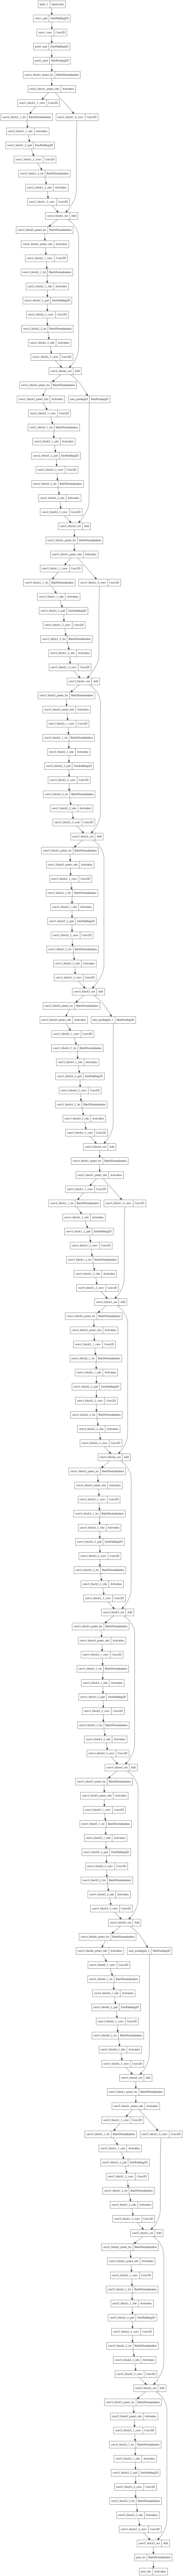

In [16]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.resnet_v2 import preprocess_input

X_train_ft = preprocess_input(X_train*255)
X_val_ft = preprocess_input(X_val*255)
X_test_ft = preprocess_input(X_test*255)

supernet = tfk.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

supernet.summary()
tfk.utils.plot_model(supernet)

In [19]:
#Create the Model
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Use the supernet as feature extractor
    supernet.trainable = False

    inputs = tfk.Input(shape=input_shape)
    #x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
    supernet_layer = supernet(inputs)

    #flattening = tfkl.Flatten(name='Flattening')(supernet_layer)
    #flattening= tfkl.Dropout(0.2, seed=seed)(x)
    flattening = tfkl.GlobalAveragePooling2D(name='GlobalAVGPool')(supernet_layer)

    classifier_0 = stackDenseLayer("classifier_0",flattening,size=256,GlorthUniform=True,drop_out=True,drop_rate=0.2)
    #classifier_1 = stackDenseLayer("classifier_1",classifier_0,size=128,GlorthUniform=True,drop_out=True,drop_rate=0.2)
    #classifier_2 = stackDenseLayer("classifier_2",classifier_1,size=64,GlorthUniform=True,drop_out=True,drop_rate=0.2)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_0)

    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='Xception')

    # Compile the model
    tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy',F1])
    return tl_model

# Training Phase
Compile the model, configure all necessary infomation for training like epoch,batches, callbacks...
Then start the training

### Compile the model

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 GlobalAVGPool (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 classifier_0 (Dense)        (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                          

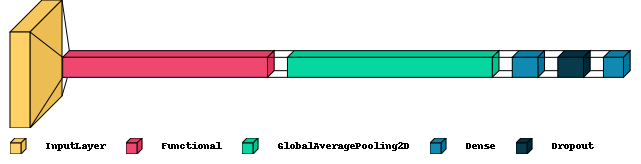

In [20]:
#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

### Train the model

In [21]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,where_to_save="./local_checkpoints/",patience=15,model_name="ResNet_Base")

#Fit the model
history = model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_ft, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200
98/98 [==============================] - 23s 109ms/step - loss: 1.6654 - accuracy: 0.3793 - F1: 0.2172 - val_loss: 1.3419 - val_accuracy: 0.5031 - val_F1: 0.3101
Epoch 2/200
98/98 [==============================] - 8s 83ms/step - loss: 1.3000 - accuracy: 0.5169 - F1: 0.4021 - val_loss: 1.2384 - val_accuracy: 0.5440 - val_F1: 0.4292
Epoch 3/200
98/98 [==============================] - 8s 85ms/step - loss: 1.1557 - accuracy: 0.5769 - F1: 0.4873 - val_loss: 1.2074 - val_accuracy: 0.5692 - val_F1: 0.4803
Epoch 4/200
98/98 [==============================] - 8s 83ms/step - loss: 1.0282 - accuracy: 0.6301 - F1: 0.5672 - val_loss: 1.1844 - val_accuracy: 0.5629 - val_F1: 0.5147
Epoch 5/200
98/98 [==============================] - 8s 84ms/step - loss: 0.8979 - accuracy: 0.6804 - F1: 0.6305 - val_loss: 1.1525 - val_accuracy: 0.5660 - val_F1: 0.5338
Epoch 6/200
98/98 [==============================] - 8s 83ms/step - loss: 0.8065 - accuracy: 0.7178 - F1: 0.6777 - val_loss: 1.2595 - val_

In [22]:
model_helper.save_model(model,"ResNet50-Base")

12/12 [==============================] - 2s 61ms/step
Accuracy: 0.5508
Precision: 0.5266
Recall: 0.5287
F1: 0.5253


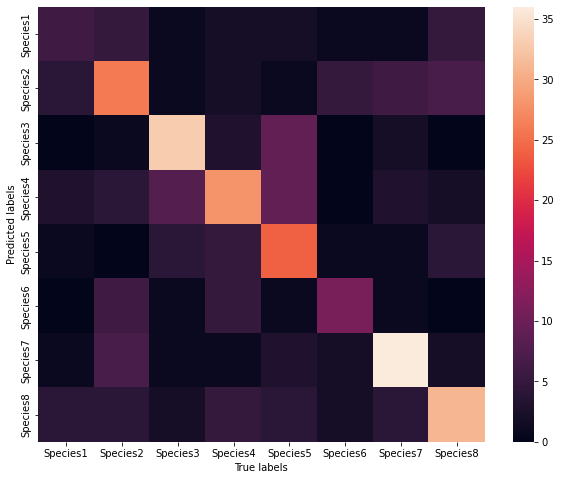

BABABA


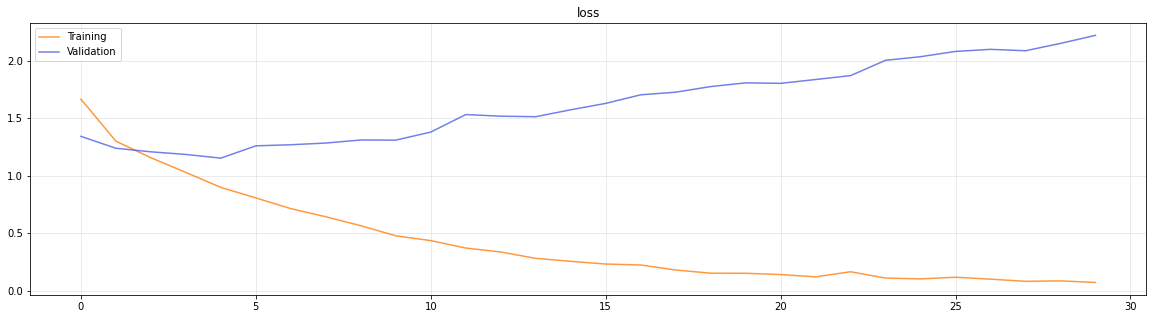

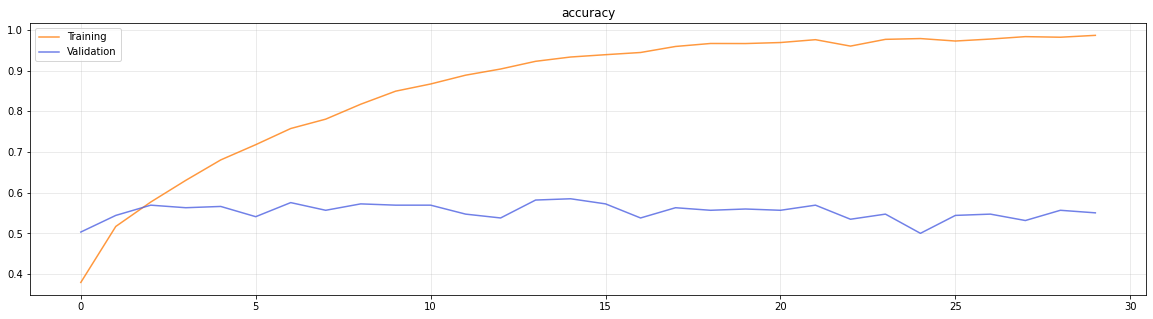

In [23]:
model_helper.show_confusion_matrix(X_test_ft,Y_test)
model_helper.plot_phase_train_vs_validation(history)

# Step 2 -> Fine tuning 100 layer freezed

In [24]:
#ft_model = model_helper.load_model("Xception_Freezed_CNN_AvgPooling3Dense",)
ft_model = tf.keras.models.load_model("local_saved_models/ResNet50-Base",custom_objects = {"F1":F1})
ft_model.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 GlobalAVGPool (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 classifier_0 (Dense)        (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056      
                                                          

In [25]:
num_of_freezed_layer = 1
# Freeze first N layers, e.g., until 14th
ft_model.get_layer('resnet50v2').trainable = True
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:num_of_freezed_layer]):
    layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d Tru

In [26]:
# Compile the model
model_name = "Resnet50-ft-"+str(num_of_freezed_layer) + "-layers"
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy',F1])

In [27]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,tensorboard=True,where_to_save="./local_checkpoints/",patience=15,model_name=model_name)

#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

#Fit the model
history = ft_model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_ft, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200
98/98 [==============================] - 42s 332ms/step - loss: 1.9566 - accuracy: 0.4181 - F1: 0.3106 - val_loss: 1.5312 - val_accuracy: 0.4623 - val_F1: 0.4331
Epoch 2/200
98/98 [==============================] - 30s 308ms/step - loss: 1.0398 - accuracy: 0.6094 - F1: 0.5568 - val_loss: 1.0596 - val_accuracy: 0.5975 - val_F1: 0.5706
Epoch 3/200
98/98 [==============================] - 30s 307ms/step - loss: 0.6790 - accuracy: 0.7558 - F1: 0.7414 - val_loss: 0.9538 - val_accuracy: 0.6572 - val_F1: 0.6752
Epoch 4/200
98/98 [==============================] - 30s 306ms/step - loss: 0.4471 - accuracy: 0.8461 - F1: 0.8396 - val_loss: 1.0260 - val_accuracy: 0.6824 - val_F1: 0.6800
Epoch 5/200
98/98 [==============================] - 30s 302ms/step - loss: 0.2335 - accuracy: 0.9288 - F1: 0.9247 - val_loss: 1.1269 - val_accuracy: 0.6730 - val_F1: 0.6797
Epoch 6/200
98/98 [==============================] - 30s 304ms/step - loss: 0.2483 - accuracy: 0.9169 - F1: 0.9108 - val_loss: 1.2

In [28]:
model_helper.save_model(ft_model,model_name)

12/12 [==============================] - 1s 28ms/step
Accuracy: 0.7401
Precision: 0.7189
Recall: 0.6947
F1: 0.702


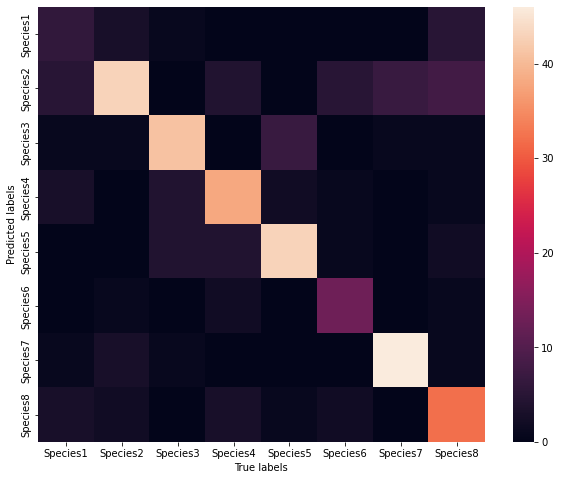

BABABA


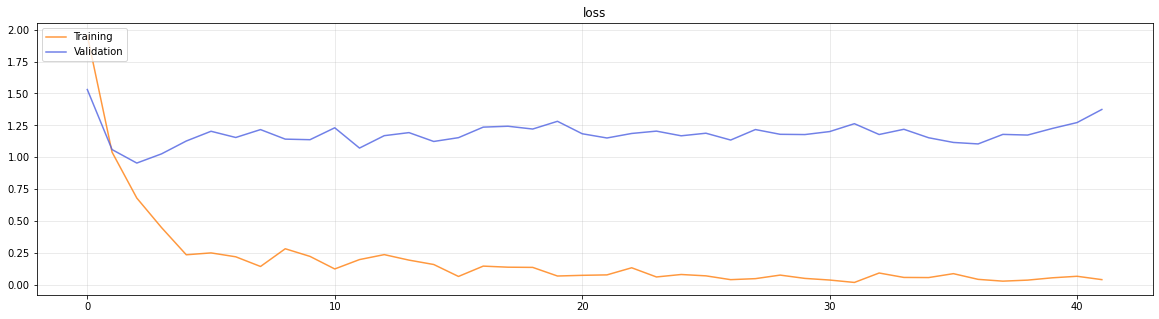

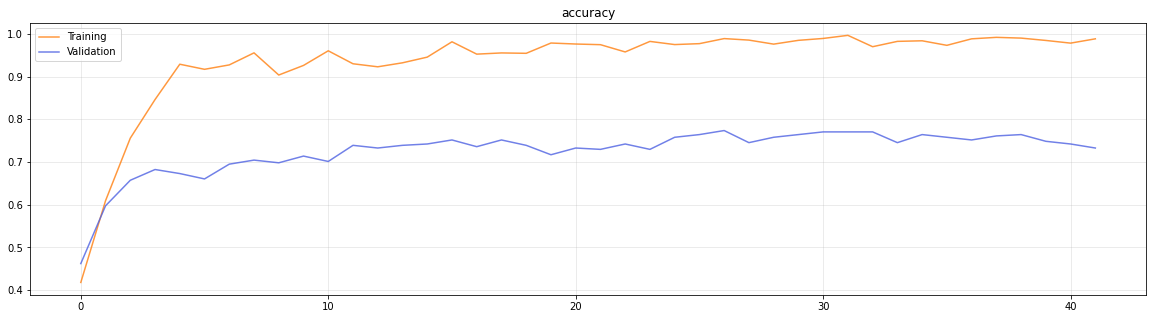

In [29]:
model_helper.show_confusion_matrix(X_test_ft,Y_test)
model_helper.plot_phase_train_vs_validation(history)

# STEP 3 -> Change augmentation seed and train some other epoche with 150 freezed layer

In [ ]:
dataset_helper.seed = 4349

In [ ]:
#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])

X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_t_original,Y_t_original,30000, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                zoom_range=0.9,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.5, 1.1))

Data Augmentation with data distribution
Data distribution = [0.13195833 0.12259167 0.123025   0.12315833 0.122625   0.13095833
 0.12245833 0.123225  ]
Class Size :  151, generating: 3958
3720 images generated
Class Size :  432, generating: 3677
3520 images generated
Class Size :  419, generating: 3690
3448 images generated
Class Size :  415, generating: 3694
3672 images generated
Class Size :  431, generating: 3678
3512 images generated
Class Size :  181, generating: 3928
3684 images generated
Class Size :  436, generating: 3673
3552 images generated
Class Size :  413, generating: 3696
3656 images generated


In [ ]:
X_train_ft = preprocess_input(X_train*255)

In [ ]:
num_of_freezed_layer = 150
# Freeze first N layers, e.g., until 14th
ft_model.get_layer('resnet50v2').trainable = True
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:num_of_freezed_layer]):
    layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
# Compile the model
model_name = "Resnet50-ft-"+str(num_of_freezed_layer) + "-layers"
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['accuracy',F1])

In [ ]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,tensorboard=True,patience=10,model_name=model_name)

#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 30

#Fit the model
history = ft_model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_ft, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/30
247/248 [============================>.] - ETA: 0s - loss: 0.8382 - accuracy: 0.7156 - F1: 0.6950

2022-11-17 22:38:16.595888: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


248/248 [==============================] - ETA: 0s - loss: 0.8380 - accuracy: 0.7155 - F1: 0.6949

2022-11-17 22:38:17.167319: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-17 22:38:17.182861: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


248/248 [==============================] - 68s 257ms/step - loss: 0.8380 - accuracy: 0.7155 - F1: 0.6949 - val_loss: 0.6728 - val_accuracy: 0.7893 - val_F1: 0.7984
Epoch 2/30
248/248 [==============================] - 61s 245ms/step - loss: 0.5910 - accuracy: 0.7819 - F1: 0.7788 - val_loss: 0.7798 - val_accuracy: 0.7736 - val_F1: 0.7784
Epoch 3/30
248/248 [==============================] - 61s 247ms/step - loss: 0.3814 - accuracy: 0.8614 - F1: 0.8610 - val_loss: 1.1182 - val_accuracy: 0.7673 - val_F1: 0.7567
Epoch 4/30
248/248 [==============================] - 61s 245ms/step - loss: 0.1964 - accuracy: 0.9318 - F1: 0.9329 - val_loss: 1.2260 - val_accuracy: 0.7736 - val_F1: 0.7763
Epoch 5/30
248/248 [==============================] - 61s 248ms/step - loss: 0.1226 - accuracy: 0.9593 - F1: 0.9600 - val_loss: 1.5338 - val_accuracy: 0.7704 - val_F1: 0.7648
Epoch 6/30
248/248 [==============================] - 61s 247ms/step - loss: 0.0739 - accuracy: 0.9753 - F1: 0.9754 - val_loss: 1.7115 -

In [ ]:
model_name = model_name+"-step3"
model_helper.save_model(ft_model,model_name)

INFO:tensorflow:Assets written to: ../../local_saved_models/Resnet50-ft-150-layers-step3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/Resnet50-ft-150-layers-step3/assets


12/12 [==============================] - 2s 60ms/step
Accuracy: 0.7966
Precision: 0.8035
Recall: 0.7611
F1: 0.7709


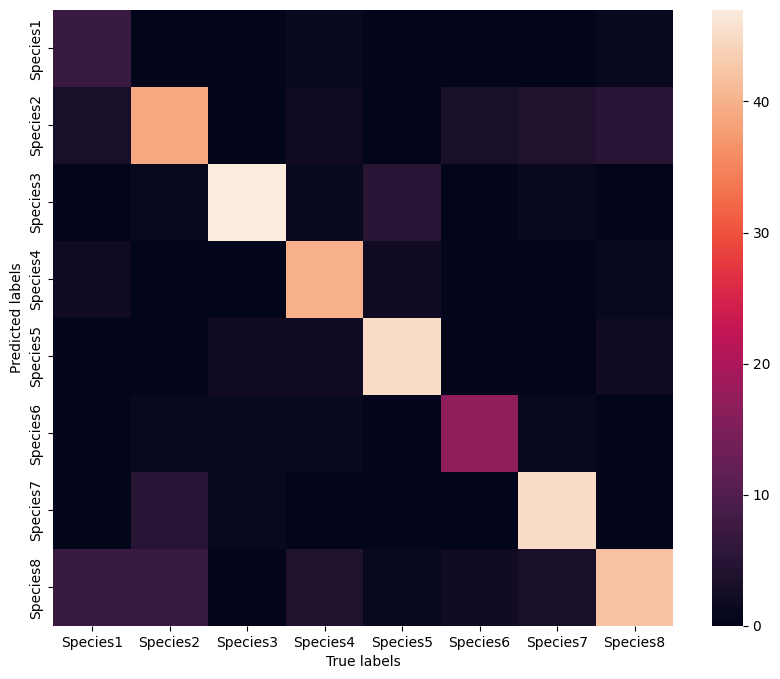

BABABA


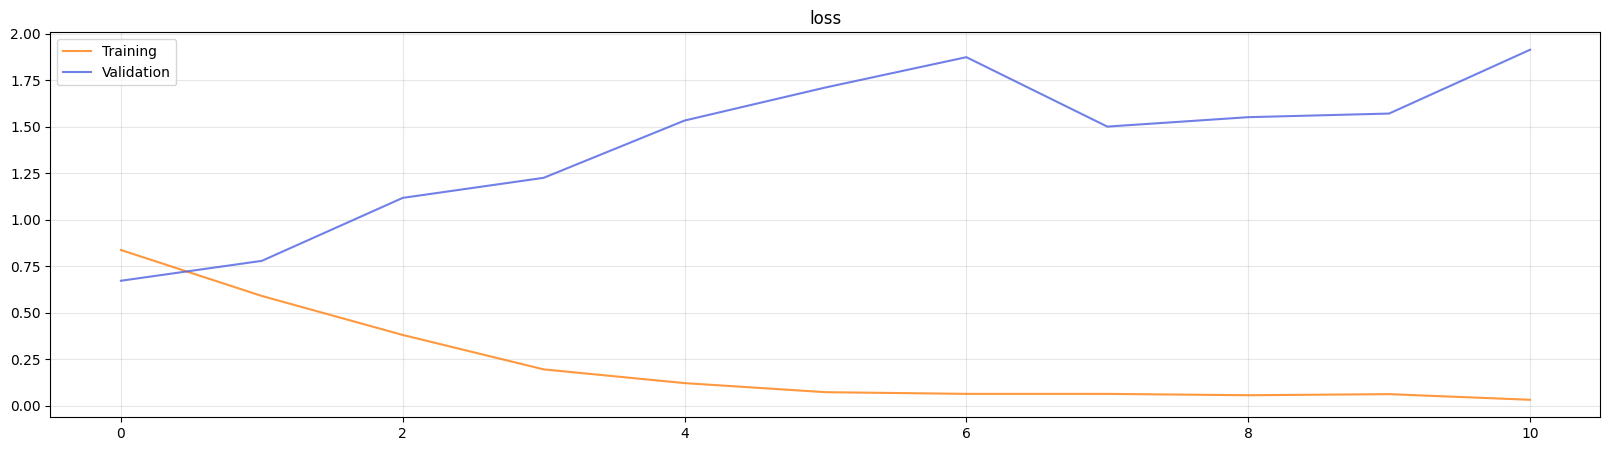

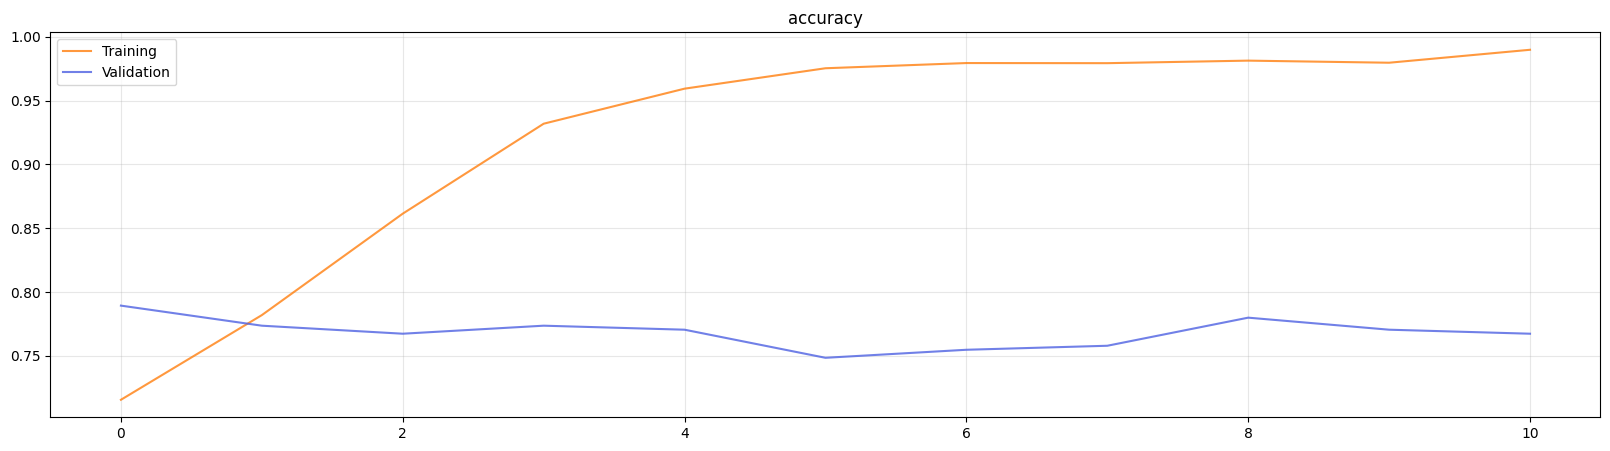

In [ ]:
model_helper.show_confusion_matrix(X_test_ft,Y_test)
model_helper.plot_phase_train_vs_validation(history)